# Convnet Model and Training

This aim of notebook is to define the siamese model that will be used for the Humpback Whale challenge. It will also run the model to trainin it agains our previously generated training and validation dataset and also create the results agains a test dataset.

## 0. Module Imports 

In [1]:
import numpy as np
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

## 1. Load Training, Validation and Test datasets

In [2]:
pickle_file = '../data/Siamese_dataset.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X1_dataset = save['train_X1_dataset']
    train_X2_dataset = save['train_X2_dataset']
    train_labels = save['train_labels']
    valid_X1_dataset = save['valid_X1_dataset']
    valid_X2_dataset = save['valid_X2_dataset']
    valid_labels = save['valid_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_X1_dataset.shape, train_X2_dataset.shape, train_labels.shape)
    print('Validation set', valid_X1_dataset.shape, valid_X2_dataset.shape, valid_labels.shape)
    train_labels = np.ones(train_labels.shape,dtype=float) - train_labels
    valid_labels = np.ones(valid_labels.shape,dtype=float) - valid_labels

Training set (31218, 44, 100) (31218, 44, 100) (31218,)
Validation set (5510, 44, 100) (5510, 44, 100) (5510,)


##  2. Declaration of Global Constants
Now we declare all the global constants in hee in orde to have them centralized.
This way we can easyly tune our model.

In [37]:
## Image parameters
NUM_CHANNELS = 1
IMAGE_HEIGHT = train_X1_dataset.shape[1]
IMAGE_WIDHT = train_X1_dataset.shape[2]

#Convnet parameters
BETA = 0.005
PATCH_1 = 7
PATCH_2 = 6
DEPTH_1 = 15
DEPTH_2 = 45
NUM_HIDEN = 1024
NUM_LABELS = 1
MARGIN = 2.0


#Training parameters
BATCH_SIZE = 128
NUM_STEPS = 1501
THRESHOLD = 9.5

## 3. Reformat datasets into a TensorFlow-friendly shape:

- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.



In [4]:
num_labels = 1

def reformat(dataset1, dataset2, labels):
  dataset1 = dataset1.reshape(
    (-1, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS)).astype(np.float32)
  dataset2 = dataset2.reshape(
    (-1, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset1, dataset2, labels
train_X1_dataset, train_X2_dataset, train_labels = reformat(train_X1_dataset, train_X2_dataset, train_labels)
valid_X1_dataset, valid_X2_dataset, valid_labels = reformat(valid_X1_dataset, valid_X2_dataset, valid_labels)
print('Training set', train_X1_dataset.shape, train_X2_dataset.shape, train_labels.shape)
print('Validation set', valid_X1_dataset.shape, valid_X2_dataset.shape, valid_labels.shape)

Training set (31218, 44, 100, 1) (31218, 44, 100, 1) (31218, 1)
Validation set (5510, 44, 100, 1) (5510, 44, 100, 1) (5510, 1)


## 4. Definition of auxiliar functions

### 4.1. Accuracy computation

In [71]:
def accuracy(distance, labels):
    positives = np.where(labels[:, 0] > 0)
    negatives = np.where(labels[:, 0] == 0)
    mean_p_distance = np.mean(distance[positives[0]])
    mean_n_distance = np.mean(distance[negatives[0]])
    aux = distance < (mean_p_distance + mean_n_distance)/2
    equal = np.equal(aux[:] , labels[:, 0])
    great = np.greater(aux[:] , labels[:, 0])
    less = np.less(aux[:] , labels[:, 0])
    acc = (100.0 * np.sum(equal.astype(np.float32))
          / distance.shape[0])
    false_pos = np.sum(great.astype(np.float32))
    false_neg = np.sum(less.astype(np.float32))
    return acc, false_pos, false_neg

def print_means(distance, labels):
    print(distance.shape)
    print(labels.shape)
    positives = np.where(labels[:, 0] > 0)
    negatives = np.where(labels[:, 0] == 0)
    print(positives[0].shape)
    print(negatives[0].shape)
    mean_p_distance = np.mean(distance[positives[0]])
    mean_n_distance = np.mean(distance[negatives[0]])
    
    
    plt.figure(figsize=(10, 4))

    # the histogram of the data
    n, bins, patches = plt.hist(distance[positives[0]], 100, normed=1, facecolor='green', alpha=0.2)
    n, bins, patches = plt.hist(distance[negatives[0]], 100, normed=1, facecolor='red', alpha=0.2)

    plt.xlabel('Aspect ratio')
    plt.ylabel('Probability')
    plt.title('Histogram of Aspect Ratios')
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    plt.show()
    
    print('Mean negative distance ' +  str(mean_n_distance) + ' mean positive distance ' + str(mean_p_distance))

## 5. Network declaration
We will use tensorflow

In [ ]:

siamese_model = tf.Graph()

with siamese_model.as_default():

  # Input data.
    tf_train_X1_dataset = tf.placeholder(\
          tf.float32, shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS))
    tf_train_X2_dataset = tf.placeholder(\
          tf.float32, shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_X1_dataset = tf.constant(valid_X1_dataset)
    tf_valid_X2_dataset = tf.constant(valid_X2_dataset)
    #tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    weights = {
      'layer1': tf.Variable(tf.truncated_normal(\
              [PATCH_1, PATCH_1, NUM_CHANNELS, DEPTH_1], stddev=0.1)),
      'layer2': tf.Variable(tf.truncated_normal(\
              [PATCH_2, PATCH_2, DEPTH_1, DEPTH_2], stddev=0.1)),
      'layer3': tf.Variable(tf.truncated_normal(\
              [IMAGE_HEIGHT // 4 * (IMAGE_WIDHT // 4 ) * DEPTH_2, NUM_HIDEN], stddev=0.1)),
      'layer4': tf.Variable(tf.truncated_normal(\
              [NUM_HIDEN, 10], stddev=0.1))
      }
    biases = {
        'layer1' : tf.Variable(tf.zeros([DEPTH_1])),
        'layer2' : tf.Variable(tf.constant(1.0, shape=[DEPTH_2])),
        'layer3' : tf.Variable(tf.constant(1.0, shape=[NUM_HIDEN])),
        'layer4' : tf.Variable(tf.constant(1.0, shape=[1]))
        }
  
  # Model.
    def model(data):
        conv = tf.nn.conv2d(data, weights['layer1'], [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases['layer1'])
        conv = tf.nn.conv2d(hidden, weights['layer2'], [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases['layer2'])
        shape = hidden.get_shape().as_list()
        print(shape)
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, weights['layer3']) + biases['layer3'])
        return tf.matmul(hidden, weights['layer4']) + biases['layer4']
    
    
  # Training computation.
    with tf.variable_scope("siamese") as scope:
        logits1 = model(tf_train_X1_dataset)
        scope.reuse_variables()
        logits2 = model(tf_train_X2_dataset)
        
    with tf.variable_scope("siamese_val") as scope:
        val_logits1 = model(tf_valid_X1_dataset)
        scope.reuse_variables()
        val_logits2 = model(tf_valid_X2_dataset)
        
    def loss(y):
        labels_t = y
        labels_f = tf.subtract(1.0, y, name="1-yi")          # labels_ = !labels;
        eucd2 = tf.pow(tf.subtract(logits1, logits2), 2)
        eucd2 = tf.reduce_sum(eucd2, 1)
        eucd = tf.sqrt(eucd2+1e-6, name="eucd")
        C = tf.constant(MARGIN, name="C")
        # yi*||CNN(p1i)-CNN(p2i)||^2 + (1-yi)*max(0, C-||CNN(p1i)-CNN(p2i)||^2)
        pos = tf.multiply(labels_t, eucd2, name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.subtract(0.0,eucd2), name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.maximum(0.0, tf.subtract(C,eucd2)), name="Nyi_x_C-eucd_xx_2")
        neg = tf.multiply(labels_f, tf.pow(tf.maximum(tf.subtract(C, eucd), 0), 2), name="Nyi_x_C-eucd_xx_2")
        losses = tf.add(pos, neg, name="losses")
        loss = tf.reduce_mean(losses, name="loss")
        return loss
    
    def loss_paper(y):
        labels_i = y
        labels_g = tf.subtract(1.0, y, name="1-yi")          # labels_ = !labels;
        ew2 = tf.pow(tf.subtract(logits1, logits2), 2)
        ew2 = tf.reduce_sum(ew2, 1)
        ew = tf.sqrt(ew2+1e-6, name="ew")
        Q = tf.constant(MARGIN, name="Q")
        # yi*||CNN(p1i)-CNN(p2i)||^2 + (1-yi)*max(0, C-||CNN(p1i)-CNN(p2i)||^2)
        pos = labels_g * ew2 * 2 / Q
        # neg = tf.multiply(labels_f, tf.subtract(0.0,eucd2), name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.maximum(0.0, tf.subtract(C,eucd2)), name="Nyi_x_C-eucd_xx_2")
        neg = labels_i *2 * Q * tf.exp( - 2.77 * ew / Q) 
        losses = tf.add(pos, neg, name="losses")
        loss = tf.reduce_mean(losses, name="loss")
        return loss
    
        
    loss = loss_paper(tf_train_labels)
    
  # Optimizer.
    optimizer = tf.train.AdamOptimizer().minimize(loss)
  
  
  # Predictions for the training, validation, and test data.
    #train_prediction = tf.reduce_sum(tf.pow(tf.subtract(logits1, logits2), 2),1)
    #valid_prediction = tf.reduce_sum(tf.pow(tf.subtract(val_logits1, val_logits2), 2),1)
    #test_prediction = tf.nn.softmax(model(tf_test_dataset))

    num = tf.reduce_sum(logits1 * logits2, axis = 1)
    print(num.shape)
    den = tf.sqrt(tf.reduce_sum(tf.pow(logits1, 2),1)) * tf.sqrt(tf.reduce_sum(tf.pow(logits2, 2),1))
    train_prediction = num/den
    num = tf.reduce_sum(val_logits1 * val_logits2, axis = 1)
    den = tf.sqrt(tf.reduce_sum(tf.pow(val_logits1, 2),1)) * tf.sqrt(tf.reduce_sum(tf.pow(val_logits2, 2),1))
    valid_prediction = num/den

[128, 11, 25, 45]
[128, 11, 25, 45]
[5510, 11, 25, 45]
[5510, 11, 25, 45]
(128,)


## 6. Model training

Initialized
Minibatch loss at step 0 91.703666687
Minibatch accuracy: 36.71875 false positives: 34.0 false negatives: 47.0
Validation accuracy: 34.0834845735 false positives: 1338.0 false negatives: 2294.0
(5510,)
(5510, 1)
(2582,)
(2928,)


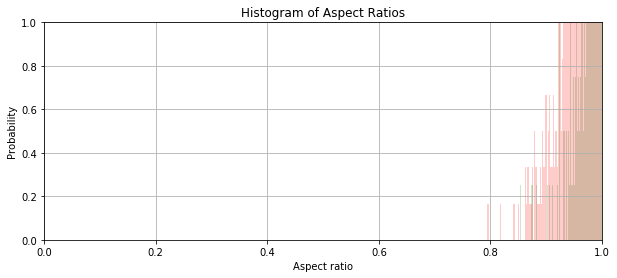

Mean negative distance 0.982931 mean positive distance 0.994223
Minibatch loss at step 50 7.2212805748
Minibatch accuracy: 45.3125 false positives: 34.0 false negatives: 36.0
Validation accuracy: 45.9528130672 false positives: 1314.0 false negatives: 1664.0
(5510,)
(5510, 1)
(2582,)
(2928,)


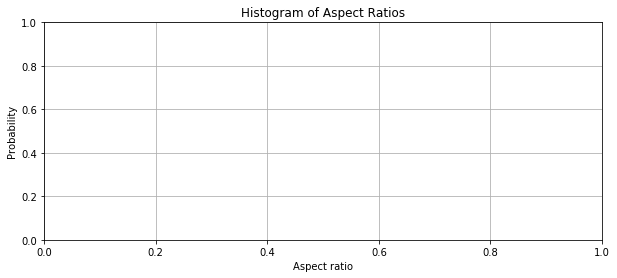

Mean negative distance 0.999782 mean positive distance 0.999805
Minibatch loss at step 100 3.04331684113
Minibatch accuracy: 35.15625 false positives: 37.0 false negatives: 46.0
Validation accuracy: 47.277676951 false positives: 1272.0 false negatives: 1633.0
(5510,)
(5510, 1)
(2582,)
(2928,)


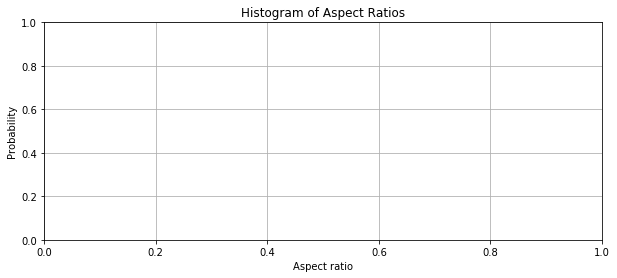

Mean negative distance 0.999858 mean positive distance 0.999869
Minibatch loss at step 150 2.52400445938
Minibatch accuracy: 44.53125 false positives: 32.0 false negatives: 39.0
Validation accuracy: 48.3666061706 false positives: 1231.0 false negatives: 1614.0
(5510,)
(5510, 1)
(2582,)
(2928,)


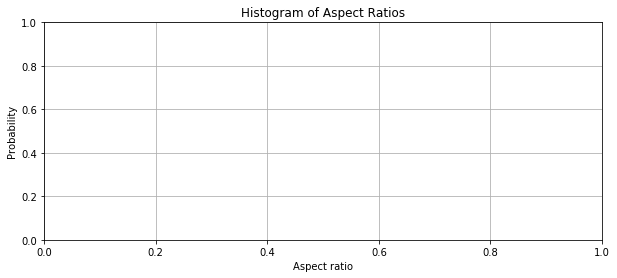

Mean negative distance 0.999881 mean positive distance 0.999891
Minibatch loss at step 200 1.98825383186
Minibatch accuracy: 49.21875 false positives: 29.0 false negatives: 36.0
Validation accuracy: 47.22323049 false positives: 1258.0 false negatives: 1650.0
(5510,)
(5510, 1)
(2582,)
(2928,)


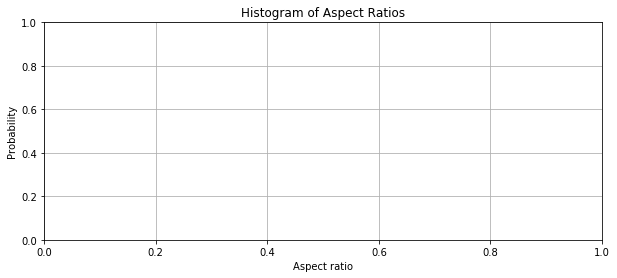

Mean negative distance 0.999901 mean positive distance 0.999909


In [ ]:
#Plots
P_FREQ = 50
losses = []
accuracies = []
rates = []

with tf.Session(graph=siamese_model) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(NUM_STEPS):
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
    batch_data_X1 = train_X1_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_data_X2 = train_X2_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
    feed_dict = {tf_train_X1_dataset : batch_data_X1, tf_train_X2_dataset : batch_data_X2, \
                 tf_train_labels : batch_labels}
    _, _loss, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if np.isnan(_loss):
        print('Model diverged with loss = NaN')
        quit()
        
    #Plot variables
    if (step % P_FREQ == 0):
      losses.append(_loss)
      distances = valid_prediction.eval()
      acc, fp, fn = accuracy(distances, valid_labels)
      accuracies.append(acc)
      rates.append(float(fp/fn))
    
    if (step % 50 == 0):
      print('Minibatch loss at step {} {}'.format(step, _loss))
      a = accuracy(predictions, batch_labels)
      print('Minibatch accuracy: {} false positives: {} false negatives: {}'.format(a[0], a[1], a[2] ) )
      a = accuracy(valid_prediction.eval(), valid_labels)
      print('Validation accuracy: {} false positives: {} false negatives: {}'.format(a[0], a[1], a[2] ) )
      print_means(valid_prediction.eval(), valid_labels)
#print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

# Show the results.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=.8)
fig.set_size_inches(10, 4)
ax1.plot(range(0, NUM_STEPS, P_FREQ), losses)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training steps")
ax2.plot(range(0, NUM_STEPS, P_FREQ), accuracies)
ax2.set_ylabel("Validation Accuracy [%]")
ax2.set_xlabel("Training steps")
ax3.plot(range(0, NUM_STEPS, P_FREQ), rates)
ax3.set_ylabel("FP / FN [%]")
ax3.set_xlabel("Training steps")
plt.show()


In [27]:
print(valid_labels.shape)

(5510, 1)


In [9]:
print(predictions.shape)

(128,)


In [10]:
print(hey)

NameError: name 'hey' is not defined

In [ ]:
a = hey < 5.0
print(a.astype(np.float32))

In [ ]:
print(_valid_labels)
print(valid_labels)

In [ ]:
print(a[23].astype(np.float32))
print(valid_labels[23])

In [ ]:
def accuracy_dbg(predictions, labels, print_nr = 0):
    aux = predictions < MARGIN
    equal = np.equal(aux[:] , labels[:,0])
    print(predictions[print_nr])
    print(labels[print_nr])
    print(aux[print_nr].astype(np.float32))
    print(aux.shape)
    print(labels.shape)
    print(equal.shape)
    print(predictions.shape)
    acc = (100.0 * np.sum(equal.astype(np.float32))
          / predictions.shape[0])
    false_pos = 12
    false_neg = 122
    return acc, false_pos, false_neg
a = accuracy_dbg(hey, valid_labels, 24)
print(a)
print(" {} {} {}".format(a[0], a[1], a[2]))

In [ ]:
a = np.array([0, 1, 1, 1, 1, 0, 0, 0])
b = np.where(a == 0)
c = a[b]
print(c)

In [64]:
a = np.ones([10,2]) * 2
b = np.ones([10,2]) * 3
print (a)
print(b)

c = a *b
 
print(c)

[[ 2.  2.]
 [ 2.  2.]
 [ 2.  2.]
 [ 2.  2.]
 [ 2.  2.]
 [ 2.  2.]
 [ 2.  2.]
 [ 2.  2.]
 [ 2.  2.]
 [ 2.  2.]]
[[ 3.  3.]
 [ 3.  3.]
 [ 3.  3.]
 [ 3.  3.]
 [ 3.  3.]
 [ 3.  3.]
 [ 3.  3.]
 [ 3.  3.]
 [ 3.  3.]
 [ 3.  3.]]
[[ 6.  6.]
 [ 6.  6.]
 [ 6.  6.]
 [ 6.  6.]
 [ 6.  6.]
 [ 6.  6.]
 [ 6.  6.]
 [ 6.  6.]
 [ 6.  6.]
 [ 6.  6.]]
